# Advanced Retrieval with LangChain

In the following notebook, we'll explore various methods of advanced retrieval using LangChain!

We'll touch on:

- 🔍 **Naive Retrieval**
- 🎯 **Best-Matching 25 (BM25)**
- 🔀 **Multi-Query Retrieval**
- 📁 **Parent-Document Retrieval**
- ⚖️ **Contextual Compression (a.k.a. Rerank)**
- 🎼 **Ensemble Retrieval**
- 🧩 **Semantic chunking**

We'll also discuss how these methods impact performance on our set of documents with a simple RAG chain.

There will be two breakout rooms:

- 🤝 Breakout Room Part #1
  - Task 1: Getting Dependencies!
  - Task 2: Data Collection and Preparation
  - Task 3: Setting Up QDrant!
  - Task 4-10: Retrieval Strategies
- 🤝 Breakout Room Part #2
  - Activity: Evaluate with Ragas

# 🤝 Breakout Room Part #1

## Task 1: Getting Dependencies!

We're going to need a few specific LangChain community packages, like OpenAI (for our [LLM](https://platform.openai.com/docs/models) and [Embedding Model](https://platform.openai.com/docs/guides/embeddings)) and Cohere (for our [Reranker](https://cohere.com/rerank)).

We'll also provide our OpenAI key, as well as our Cohere API key.

In [ ]:
import os
import getpass
from uuid import uuid4

os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter your OpenAI API Key:")

# Enable LangSmith tracing
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_API_KEY"] = getpass.getpass("LangChain API Key:")
os.environ["LANGCHAIN_PROJECT"] = f"AIM - SDG - retrievers comparison - {uuid4().hex[0:8]}"

os.environ["COHERE_API_KEY"] = getpass.getpass("Cohere API Key:")

## Task 2: Data Collection and Preparation

We'll be using our Use Case Data once again - this time the strutured data available through the CSV!

### Data Preparation

We want to make sure all our documents have the relevant metadata for the various retrieval strategies we're going to be applying today.

In [59]:
from langchain_community.document_loaders.csv_loader import CSVLoader
from datetime import datetime, timedelta

loader = CSVLoader(
    file_path=f"./data/Projects_with_Domains.csv",
    metadata_columns=[
      "Project Title",
      "Project Domain",
      "Secondary Domain",
      "Description",
      "Judge Comments",
      "Score",
      "Project Name",
      "Judge Score"
    ]
)

synthetic_usecase_data = loader.load()

for doc in synthetic_usecase_data:
    doc.page_content = doc.metadata["Description"]

Let's look at an example document to see if everything worked as expected!

In [60]:
synthetic_usecase_data[0]

Document(metadata={'source': './data/Projects_with_Domains.csv', 'row': 0, 'Project Title': 'InsightAI 1', 'Project Domain': 'Security', 'Secondary Domain': 'Finance / FinTech', 'Description': 'A low-latency inference system for multimodal agents in autonomous systems.', 'Judge Comments': 'Technically ambitious and well-executed.', 'Score': '85', 'Project Name': 'Project Aurora', 'Judge Score': '9.5'}, page_content='A low-latency inference system for multimodal agents in autonomous systems.')

## Task 3: Setting up QDrant!

Now that we have our documents, let's create a QDrant VectorStore with the collection name "Synthetic_Usecases".

We'll leverage OpenAI's [`text-embedding-3-small`](https://openai.com/blog/new-embedding-models-and-api-updates) because it's a very powerful (and low-cost) embedding model.

> NOTE: We'll be creating additional vectorstores where necessary, but this pattern is still extremely useful.

In [61]:
from langchain_community.vectorstores import Qdrant
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

vectorstore = Qdrant.from_documents(
    synthetic_usecase_data,
    embeddings,
    location=":memory:",
    collection_name="Synthetic_Usecases"
)

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


## Task 4: Naive RAG Chain

Since we're focusing on the "R" in RAG today - we'll create our Retriever first.

### R - Retrieval

This naive retriever will simply look at each review as a document, and use cosine-similarity to fetch the 10 most relevant documents.

> NOTE: We're choosing `10` as our `k` here to provide enough documents for our reranking process later

In [62]:
naive_retriever = vectorstore.as_retriever(search_kwargs={"k" : 10})

### A - Augmented

We're going to go with a standard prompt for our simple RAG chain today! Nothing fancy here, we want this to mostly be about the Retrieval process.

In [63]:
from langchain_core.prompts import ChatPromptTemplate

RAG_TEMPLATE = """\
You are a helpful and kind assistant. Use the context provided below to answer the question.

If you do not know the answer, or are unsure, say you don't know.

Query:
{question}

Context:
{context}
"""

rag_prompt = ChatPromptTemplate.from_template(RAG_TEMPLATE)

### G - Generation

We're going to leverage `gpt-4.1-nano` as our LLM today, as - again - we want this to largely be about the Retrieval process.

In [64]:
from langchain_openai import ChatOpenAI

chat_model = ChatOpenAI(model="gpt-4.1-nano")

### LCEL RAG Chain

We're going to use LCEL to construct our chain.

> NOTE: This chain will be exactly the same across the various examples with the exception of our Retriever!

In [65]:
from langchain_core.runnables import RunnablePassthrough
from operator import itemgetter
from langchain_core.output_parsers import StrOutputParser

naive_retrieval_chain = (
    # INVOKE CHAIN WITH: {"question" : "<<SOME USER QUESTION>>"}
    # "question" : populated by getting the value of the "question" key
    # "context"  : populated by getting the value of the "question" key and chaining it into the base_retriever
    {"context": itemgetter("question") | naive_retriever, "question": itemgetter("question")}
    # "context"  : is assigned to a RunnablePassthrough object (will not be called or considered in the next step)
    #              by getting the value of the "context" key from the previous step
    | RunnablePassthrough.assign(context=itemgetter("context"))
    # "response" : the "context" and "question" values are used to format our prompt object and then piped
    #              into the LLM and stored in a key called "response"
    # "context"  : populated by getting the value of the "context" key from the previous step
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

Let's see how this simple chain does on a few different prompts.

> NOTE: You might think that we've cherry picked prompts that showcase the individual skill of each of the retrieval strategies - you'd be correct!

In [ ]:
naive_retrieval_chain.invoke({"question" : "What is the most common project domain?"})["response"].content

In [ ]:
naive_retrieval_chain.invoke({"question" : "Were there any usecases about security?"})["response"].content

In [ ]:
naive_retrieval_chain.invoke({"question" : "What did judges have to say about the fintech projects?"})["response"].content

Overall, this is not bad! Let's see if we can make it better!

## Task 5: Best-Matching 25 (BM25) Retriever

Taking a step back in time - [BM25](https://www.nowpublishers.com/article/Details/INR-019) is based on [Bag-Of-Words](https://en.wikipedia.org/wiki/Bag-of-words_model) which is a sparse representation of text.

In essence, it's a way to compare how similar two pieces of text are based on the words they both contain.

This retriever is very straightforward to set-up! Let's see it happen down below!


In [69]:
from langchain_community.retrievers import BM25Retriever

bm25_retriever = BM25Retriever.from_documents(synthetic_usecase_data)

We'll construct the same chain - only changing the retriever.

In [70]:
bm25_retrieval_chain = (
    {"context": itemgetter("question") | bm25_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

Let's look at the responses!

In [ ]:
bm25_retrieval_chain.invoke({"question" : "What is the most common project domain?"})["response"].content

In [ ]:
bm25_retrieval_chain.invoke({"question" : "Were there any usecases about security?"})["response"].content

In [ ]:
bm25_retrieval_chain.invoke({"question" : "What did judges have to say about the fintech projects?"})["response"].content

It's not clear that this is better or worse, if only we had a way to test this (SPOILERS: We do, the second half of the notebook will cover this)

#### ❓ Question #1:

Give an example query where BM25 is better than embeddings and justify your answer.

##### ✅ Answer
The query 
> `Which projects use Mamba-style attention?` 

is likely to return **more precise** results with a **BM25** retriever because it contains a specific techinical term ('Mamba-style attention') and the BM25 algortmith uses a keyword-based search to filter out exact matches.

On the other hand the **embeddings-based** retriever may **include additional results** with similar semantic meanings dues to its vector distance-based search approach. This may not be beneficial depending o the usecase as it might "polute" the results.

## Task 6: Contextual Compression (Using Reranking)

Contextual Compression is a fairly straightforward idea: We want to **"compress" our retrieved context into just the most useful bits**.

There are a few ways we can achieve this - but we're going to look at a specific example called reranking.

The basic idea here is this:

- We retrieve lots of documents that are very likely related to our query vector
- We "compress" those documents into a smaller set of *more* related documents using a reranking algorithm.

We'll be leveraging Cohere's Rerank model for our reranker today!

All we need to do is the following:

- Create a basic retriever
- Create a compressor (reranker, in this case)

That's it!

Let's see it in the code below!

In [74]:
from langchain.retrievers.contextual_compression import ContextualCompressionRetriever
from langchain_cohere import CohereRerank

compressor = CohereRerank(model="rerank-v3.5")
compression_retriever = ContextualCompressionRetriever(
    base_compressor=compressor, base_retriever=naive_retriever
)

Let's create our chain again, and see how this does!

In [75]:
contextual_compression_retrieval_chain = (
    {"context": itemgetter("question") | compression_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

In [ ]:
contextual_compression_retrieval_chain.invoke({"question" : "What is the most common project domain?"})["response"].content

In [ ]:
contextual_compression_retrieval_chain.invoke({"question" : "Were there any usecases about security?"})["response"].content

In [ ]:
contextual_compression_retrieval_chain.invoke({"question" : "What did judges have to say about the fintech projects?"})["response"].content

We'll need to rely on something like Ragas to help us get a better sense of how this is performing overall - but it "feels" better!

## Task 7: Multi-Query Retriever

Typically in RAG we have a single query - the one provided by the user.

What if we had....more than one query!

In essence, a Multi-Query Retriever works by:

1. Taking the original user query and creating `n` number of new user queries using an LLM.
2. Retrieving documents for each query.
3. Using all unique retrieved documents as context

So, how is it to set-up? Not bad! Let's see it down below!



In [79]:
from langchain.retrievers.multi_query import MultiQueryRetriever

multi_query_retriever = MultiQueryRetriever.from_llm(
    retriever=naive_retriever, llm=chat_model
) 

In [80]:
multi_query_retrieval_chain = (
    {"context": itemgetter("question") | multi_query_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

#### 🔍 Seeing the Dynamically Generated Queries

In [81]:
# Enable logging to see the generated queries
import logging

# Configure logging to display INFO level messages
logging.basicConfig(level=logging.INFO, format='%(levelname)s:%(name)s:%(message)s')

In [ ]:
# Now let's see the MultiQueryRetriever in action with visible query generation
print("🔍 Running MultiQueryRetriever with query logging enabled...")
print("=" * 60)

# Test with one of our sample questions
test_question = "What did judges have to say about the fintech projects?"
result = multi_query_retriever.invoke(test_question)

print("=" * 60)
print(f"✅ Retrieved {len(result)} documents")

🔍 Running MultiQueryRetriever with query logging enabled...


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:langchain.retrievers.multi_query:Generated queries: ["1. What were the opinions and comments of judges regarding the fintech projects' innovativeness and viability?", '2. How did the judges evaluate and assess the strengths and weaknesses of the fintech projects during their reviews?', "3. Can you provide insights into the judges' feedback and criteria used to judge the fintech projects?"]
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


✅ Retrieved 13 documents


In [115]:
# Configure logging to display only ERROR level messages from now on
logging.basicConfig(level=logging.ERROR, format='%(levelname)s:%(name)s:%(message)s', force=True)

In [ ]:
multi_query_retrieval_chain.invoke({"question" : "What is the most common project domain?"})["response"].content

In [ ]:
multi_query_retrieval_chain.invoke({"question" : "Were there any usecases about security?"})["response"].content

In [ ]:
multi_query_retrieval_chain.invoke({"question" : "What did judges have to say about the fintech projects?"})["response"].content

#### ❓ Question #2:

Explain how generating multiple reformulations of a user query can improve recall.

##### ✅ Answer
This strategy helps capturing documents that might be missed by a single query formulation. Also, by using different phrasings of the same intent might retrieve different documents.


## Task 8: Parent Document Retriever

A "small-to-big" strategy - the Parent Document Retriever works based on a simple strategy:

1. Each un-split "document" will be designated as a "parent document" (You could use larger chunks of document as well, but our data format allows us to consider the overall document as the parent chunk)
2. Store those "parent documents" in a memory store (not a VectorStore)
3. We will chunk each of those documents into smaller documents, and associate them with their respective parents, and store those in a VectorStore. We'll call those "child chunks".
4. When we query our Retriever, we will do a similarity search comparing our query vector to the "child chunks".
5. Instead of returning the "child chunks", we'll return their associated "parent chunks".

Okay, maybe that was a few steps - but the basic idea is this:

- Search for small documents
- Return big documents

The intuition is that we're likely to find the most relevant information by limiting the amount of semantic information that is encoded in each embedding vector - but we're likely to miss **relevant surrounding context** if we only use that information.

Let's start by creating our "parent documents" and defining a `RecursiveCharacterTextSplitter`.

In [86]:
from langchain.retrievers import ParentDocumentRetriever
from langchain.storage import InMemoryStore
from langchain_text_splitters import RecursiveCharacterTextSplitter
from qdrant_client import QdrantClient, models

parent_docs = synthetic_usecase_data
child_splitter = RecursiveCharacterTextSplitter(chunk_size=750)

We'll need to set up a new QDrant vectorstore - and we'll use another useful pattern to do so!

> NOTE: We are manually defining our embedding dimension, you'll need to change this if you're using a different embedding model.

In [87]:
from langchain_qdrant import QdrantVectorStore

client = QdrantClient(location=":memory:")

client.create_collection(
    collection_name="full_documents",
    vectors_config=models.VectorParams(size=1536, distance=models.Distance.COSINE)
)

parent_document_vectorstore = QdrantVectorStore(
    collection_name="full_documents", embedding=OpenAIEmbeddings(model="text-embedding-3-small"), client=client
)

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


Now we can create our `InMemoryStore` that will hold our "parent documents" - and build our retriever!

In [88]:
store = InMemoryStore()

parent_document_retriever = ParentDocumentRetriever(
    vectorstore = parent_document_vectorstore,
    docstore=store,
    child_splitter=child_splitter, # These are raw chuncks (not embeddings!)
)

By default, this is empty as we haven't added any documents - let's add some now!

In [ ]:
parent_document_retriever.add_documents(parent_docs, ids=None)

We'll create the same chain we did before - but substitute our new `parent_document_retriever`.

In [90]:
parent_document_retrieval_chain = (
    {"context": itemgetter("question") | parent_document_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

Let's give it a whirl!

In [ ]:
parent_document_retrieval_chain.invoke({"question" : "What is the most common project domain?"})["response"].content

In [ ]:
parent_document_retrieval_chain.invoke({"question" : "Were there any usecases about security?"})["response"].content

In [ ]:
parent_document_retrieval_chain.invoke({"question" : "What did judges have to say about the fintech projects?"})["response"].content

Overall, the performance *seems* largely the same. We can leverage a tool like [Ragas]() to more effectively answer the question about the performance.

## Task 9: Ensemble Retriever

In brief, an Ensemble Retriever simply takes 2, or more, retrievers and combines their retrieved documents based on a rank-fusion algorithm.

In this case - we're using the [Reciprocal Rank Fusion](https://plg.uwaterloo.ca/~gvcormac/cormacksigir09-rrf.pdf) algorithm.

Setting it up is as easy as providing a list of our desired retrievers - and the weights for each retriever.

In [94]:
from langchain.retrievers import EnsembleRetriever

retriever_list = [bm25_retriever, naive_retriever, parent_document_retriever, compression_retriever, multi_query_retriever]
equal_weighting = [1/len(retriever_list)] * len(retriever_list)

ensemble_retriever = EnsembleRetriever(
    retrievers=retriever_list, weights=equal_weighting
)

We'll pack *all* of these retrievers together in an ensemble chain.

In [95]:
ensemble_retrieval_chain = (
    {"context": itemgetter("question") | ensemble_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

Let's look at our results!

In [96]:
ensemble_retrieval_chain.invoke({"question" : "What is the most common project domain?"})["response"].content

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.cohere.com/v2/rerank "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:langchain.retrievers.multi_query:Generated queries: ['1. Which project domains are most frequently encountered across various industries?  ', '2. Can you identify the top project areas based on their prevalence or popularity?  ', '3. What are the leading fields or sectors in which projects are typically categorized?']
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 2

'The most common project domain among the projects listed is "Legal / Compliance," which appears three times in the dataset.'

In [ ]:
ensemble_retrieval_chain.invoke({"question" : "Were there any usecases about security?"})["response"].content

In [ ]:
ensemble_retrieval_chain.invoke({"question" : "What did judges have to say about the fintech projects?"})["response"].content

## Task 10: Semantic Chunking

While this is not a retrieval method - it *is* an effective way of increasing retrieval performance on corpora that have clean semantic breaks in them.

Essentially, Semantic Chunking is implemented by:

1. Embedding all sentences in the corpus.
2. Combining or splitting sequences of sentences based on their semantic similarity based on a number of [possible thresholding methods](https://python.langchain.com/docs/how_to/semantic-chunker/):
  - `percentile`
  - `standard_deviation`
  - `interquartile`
  - `gradient`
3. Each sequence of related sentences is kept as a document!

Let's see how to implement this!

We'll use the `percentile` thresholding method for this example which will:

Calculate all distances between sentences, and then break apart sequences of setences that exceed a given percentile among all distances.

In [99]:
from langchain_experimental.text_splitter import SemanticChunker

semantic_chunker = SemanticChunker(
    embeddings,
    breakpoint_threshold_type="percentile"
)

Now we can split our documents.

In [100]:
semantic_documents = semantic_chunker.split_documents(synthetic_usecase_data[:20])

Let's create a new vector store.

In [ ]:
semantic_vectorstore = Qdrant.from_documents(
    semantic_documents,
    embeddings,
    location=":memory:",
    collection_name="Synthetic_Usecase_Data_Semantic_Chunks"
)

We'll use naive retrieval for this example.

In [102]:
semantic_retriever = semantic_vectorstore.as_retriever(search_kwargs={"k" : 10})

Finally we can create our classic chain!

In [103]:
semantic_retrieval_chain = (
    {"context": itemgetter("question") | semantic_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

And view the results!

In [ ]:
semantic_retrieval_chain.invoke({"question" : "What is the most common project domain?"})["response"].content

In [ ]:
semantic_retrieval_chain.invoke({"question" : "Were there any usecases about security?"})["response"].content

In [ ]:
semantic_retrieval_chain.invoke({"question" : "What did judges have to say about the fintech projects?"})["response"].content

#### ❓ Question #3:

If sentences are short and highly repetitive (e.g., FAQs), how might semantic chunking behave, and how would you adjust the algorithm?

##### ✅ Answer
In such scenario the retrieval might be less precise as the results may be grouped together into one large chunk due to poor semantic distance. 
Another issue is that semantic chunking is based purely on similarity which might split Q&A pairs or merge unrelated ones.

Possible adjustments foa Q&A kind of structure:
1. Use More Aggressive Thresholding (e.g., 25th percentile)
  > This forces the chunker to be more "sensitive" and create breaks even between similar sentences.

2. Use Gradient-Based Thresholding (e.g., `breakpoint_threshold_amount=75`)
  > gradient is better at detecting subtle transitions in repetitive content. It looks for where similarity changes most rapidly, not just absolute similarity values.

3.  Preserve structural boundaries: 
  > Pre-process FAQs using RecursiveCharacterTextSplitter with FAQ-specific separators (\n\nQ:, etc.) to maintain Q&A pair integrity before applying semantic chunking.


# 🤝 Breakout Room Part #2

#### 🏗️ Activity #1

Your task is to evaluate the various Retriever methods against each other.

You are expected to:

1. Create a "golden dataset"
 - Use Synthetic Data Generation (powered by Ragas, or otherwise) to create this dataset
2. Evaluate each retriever with *retriever specific* Ragas metrics
 - Semantic Chunking is not considered a retriever method and will not be required for marks, but you may find it useful to do a "semantic chunking on" vs. "semantic chunking off" comparision between them
3. Compile these in a list and write a small paragraph about which is best for this particular data and why.

Your analysis should factor in:
  - Cost
  - Latency
  - Performance

> NOTE: This is **NOT** required to be completed in class. Please spend time in your breakout rooms creating a plan before moving on to writing code.

##### HINTS:

- LangSmith provides detailed information about latency and cost.

#### NLTK Import
To prevent errors that may occur based on OS - we'll import NLTK and download the needed packages to ensure correct handling of data.

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

#### Data Preparation
Load the PDF file.

In [121]:
from langchain_community.document_loaders import DirectoryLoader
from langchain_community.document_loaders import PyMuPDFLoader

path = "data/"
pdf_loader = DirectoryLoader(path, glob="*.pdf", loader_cls=PyMuPDFLoader)
ai_usage_docs = pdf_loader.load()

print(f"Loaded {len(ai_usage_docs)} documents")
print(f"First document: {ai_usage_docs[0].page_content[:100]}")

Loaded 64 documents
First document: NBER WORKING PAPER SERIES
HOW PEOPLE USE CHATGPT
Aaron Chatterji
Thomas Cunningham
David J. Deming
Z


#### Knowledge Graph Based Synthetic Generation

In [122]:
from ragas.llms import LangchainLLMWrapper
from ragas.embeddings import LangchainEmbeddingsWrapper
from langchain_openai import ChatOpenAI
from langchain_openai import OpenAIEmbeddings
from ragas.testset import TestsetGenerator
from ragas.testset.synthesizers import (
    SingleHopSpecificQuerySynthesizer,
    MultiHopAbstractQuerySynthesizer,
)

generator_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4.1-nano"))
generator_embeddings = LangchainEmbeddingsWrapper(OpenAIEmbeddings())

generator = TestsetGenerator(llm=generator_llm, embedding_model=generator_embeddings)

# Use a custom query distribution to avoid the buggy MultiHopSpecificQuerySynthesizer
# This distribution uses only the working synthesizers
query_distribution = [
    (SingleHopSpecificQuerySynthesizer(llm=generator_llm), 0.6),
    (MultiHopAbstractQuerySynthesizer(llm=generator_llm), 0.4),
]

dataset = generator.generate_with_langchain_docs(
    ai_usage_docs, 
    testset_size=10,
    query_distribution=query_distribution
)

/var/folders/8x/2bh7r3s13xx2z4zz4f6_gt380000gn/T/ipykernel_6347/1395949593.py:11: DeprecationWarning: LangchainLLMWrapper is deprecated and will be removed in a future version. Use the modern LLM providers instead: from ragas.llms.base import llm_factory; llm = llm_factory('gpt-4o-mini') or from ragas.llms.base import instructor_llm_factory; llm = instructor_llm_factory('openai', client=openai_client)
  generator_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4.1-nano"))
/var/folders/8x/2bh7r3s13xx2z4zz4f6_gt380000gn/T/ipykernel_6347/1395949593.py:12: DeprecationWarning: LangchainEmbeddingsWrapper is deprecated and will be removed in a future version. Use the modern embedding providers instead: embedding_factory('openai', model='text-embedding-3-small', client=openai_client) or from ragas.embeddings import OpenAIEmbeddings, GoogleEmbeddings, HuggingFaceEmbeddings
  generator_embeddings = LangchainEmbeddingsWrapper(OpenAIEmbeddings())


Applying HeadlinesExtractor:   0%|          | 0/21 [00:00<?, ?it/s]

Applying HeadlineSplitter:   0%|          | 0/64 [00:00<?, ?it/s]

Applying SummaryExtractor:   0%|          | 0/32 [00:00<?, ?it/s]

Applying CustomNodeFilter:   0%|          | 0/20 [00:00<?, ?it/s]

Applying EmbeddingExtractor:   0%|          | 0/32 [00:00<?, ?it/s]

Applying ThemesExtractor:   0%|          | 0/14 [00:00<?, ?it/s]

Applying NERExtractor:   0%|          | 0/14 [00:00<?, ?it/s]

Applying CosineSimilarityBuilder:   0%|          | 0/1 [00:00<?, ?it/s]

Applying OverlapScoreBuilder:   0%|          | 0/1 [00:00<?, ?it/s]

Generating personas:   0%|          | 0/3 [00:00<?, ?it/s]

Generating Scenarios:   0%|          | 0/2 [00:00<?, ?it/s]

Generating Samples:   0%|          | 0/10 [00:00<?, ?it/s]

In [123]:
dataset.to_pandas().to_csv("synthetic_testset.csv", index=False)
dataset.to_pandas()

,user_input,reference_contexts,reference,synthesizer_name
0,What about 2025 is important for job stuff?,[Introduction\nChatGPT launched in November 20...,"The context explains that by July 2025, 18 bil...",single_hop_specific_query_synthesizer
1,How does the Boston Marathon relate to the act...,[Table 1: ChatGPT daily message counts (millio...,The provided context does not mention the Bost...,single_hop_specific_query_synthesizer
2,How does Deming's work relate to the ways Chat...,"[Doing, and that Asking messages are consisten...",The context mentions that ChatGPT likely impro...,single_hop_specific_query_synthesizer
3,How does GPT-4 enhance digital engagement and ...,"[How does ChatGPT provide economic value, and ...",The provided context does not include specific...,single_hop_specific_query_synthesizer
4,Are Latin American users more likely to use Ch...,[6\n Who Uses ChatGPT\nIn this section we repo...,The provided context does not include specific...,single_hop_specific_query_synthesizer
5,What ChatGPT do for students?,[Variation by Age\nA subset of users self-repo...,"ChatGPT is used by users of different ages, wi...",single_hop_specific_query_synthesizer
6,How occupation impact ChatGPT work use and is ...,[<1-hop>\n\nVariation by Occupation\nFigure 23...,The context shows that different occupations h...,multi_hop_abstract_query_synthesizer
7,How conversation topics like writing and techn...,[<1-hop>\n\nVariation by Occupation\nFigure 23...,Variation by occupation shows that users in ma...,multi_hop_abstract_query_synthesizer
8,How do annotation procedures and context handl...,[<1-hop>\n\nAppendix: Classifier Validation\nT...,The annotation procedures involve comparing LL...,multi_hop_abstract_query_synthesizer
9,Considering the extensive data on ChatGPT's us...,"[<1-hop>\n\nOpenAI, “GPT-4 Technical Report,” ...",The reports indicate that ChatGPT users send o...,multi_hop_abstract_query_synthesizer


##### Retrievers definition

 * Naive
 * BM25
 * Contextual Compression (using Cohere for Rehanking)
 * Multi Query
 * Parent Document
 * Ensemble

In [ ]:
from langchain_core.runnables import RunnablePassthrough
from langchain_core.prompts import ChatPromptTemplate
from langchain_community.vectorstores import Qdrant
from langchain_community.retrievers import BM25Retriever
from langchain.storage import InMemoryStore
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain.retrievers import EnsembleRetriever, ParentDocumentRetriever
from langchain.retrievers.contextual_compression import ContextualCompressionRetriever
from langchain.retrievers.multi_query import MultiQueryRetriever
from operator import itemgetter
from qdrant_client import QdrantClient, models
from langchain_qdrant import QdrantVectorStore
from langchain_cohere import CohereRerank
from langchain_openai import OpenAIEmbeddings, ChatOpenAI


# ==================== SHARED CONSTANTS AND UTILITIES ====================

RAG_TEMPLATE = """\
You are a helpful and kind assistant. Use the context provided below to answer the question.
If you do not know the answer, or are unsure, say you don't know.

Query:
{question}

Context:
{context}
"""

DEFAULT_K = 10
EMBEDDING_MODEL = "text-embedding-3-small"
EMBEDDING_DIM = 1536  # Dimension for text-embedding-3-small
LLM_MODEL = "gpt-4.1-nano"
REHANK_MODEL = "rerank-v3.5"

embeddings = OpenAIEmbeddings(model=EMBEDDING_MODEL)
chat_model = ChatOpenAI(model=LLM_MODEL)
rag_prompt = ChatPromptTemplate.from_template(RAG_TEMPLATE)


def build_rag_chain(retriever):
    """Generic function to build a RAG chain from any retriever."""    
    chain = (
        {"context": itemgetter("question") | retriever, "question": itemgetter("question")}
        | RunnablePassthrough.assign(context=itemgetter("context"))
        | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
    )
    return chain


def create_ai_usage_vectorstore(collection_name="AI_Usage_Docs"):
    """Creates a new Qdrant VectorDB in-memory instance using ai_usage_docs."""    
    vectorstore = Qdrant.from_documents(
        ai_usage_docs,
        embeddings,
        location=":memory:",
        collection_name=collection_name
    )
    
    return vectorstore, embeddings


def create_parent_document_vectorstore(collection_name):
    """Creates a Qdrant vectorstore with manual collection setup for parent documents."""    
    client = QdrantClient(location=":memory:")
    client.create_collection(
        collection_name=collection_name,
        vectors_config=models.VectorParams(size=EMBEDDING_DIM, distance=models.Distance.COSINE)
    )
    
    return QdrantVectorStore(
        collection_name=collection_name, 
        embedding=embeddings, 
        client=client
    )

# ==================== RETRIEVER FACTORY FUNCTIONS ====================

def create_naive_retriever(k=DEFAULT_K):
    """Creates a naive vector similarity retriever."""
    vectorstore, _ = create_ai_usage_vectorstore()
    return vectorstore.as_retriever(search_kwargs={"k": k})


def create_bm25_retriever(k=DEFAULT_K):
    """Creates a BM25 keyword-based retriever."""
    bm25_retriever = BM25Retriever.from_documents(ai_usage_docs)
    bm25_retriever.k = k
    return bm25_retriever


def create_compression_retriever(base_retriever=None):
    """Creates a contextual compression retriever with reranking."""
    if base_retriever is None:
        base_retriever = create_naive_retriever()
    
    compressor = CohereRerank(model=REHANK_MODEL)
    return ContextualCompressionRetriever(
        base_compressor=compressor, 
        base_retriever=base_retriever
    )


def create_multi_query_retriever(base_retriever=None):
    """Creates a multi-query retriever that generates query variations."""
    if base_retriever is None:
        base_retriever = create_naive_retriever()
    
    return MultiQueryRetriever.from_llm(
        retriever=base_retriever, 
        llm=chat_model
    )


def create_parent_document_retriever(collection_name="ai_usage_parent_docs", chunk_size=750):
    """Creates a parent document retriever with small-to-big strategy."""    
    child_splitter = RecursiveCharacterTextSplitter(chunk_size=chunk_size)
    parent_document_vectorstore = create_parent_document_vectorstore(collection_name)
    store = InMemoryStore()
    
    retriever = ParentDocumentRetriever(
        vectorstore=parent_document_vectorstore,
        docstore=store,
        child_splitter=child_splitter,
    )
    
    # Add documents to the retriever
    retriever.add_documents(ai_usage_docs, ids=None)
    
    return retriever


def create_ensemble_retriever(weights=None):
    """Creates an ensemble retriever combining multiple retrieval strategies."""
    
    # Create all individual retrievers
    bm25_retriever = create_bm25_retriever()
    naive_retriever = create_naive_retriever()
    parent_retriever = create_parent_document_retriever(collection_name="ai_usage_ensemble_parent_docs")
    compression_retriever = create_compression_retriever(base_retriever=create_naive_retriever())
    multi_query_retriever = create_multi_query_retriever(base_retriever=create_naive_retriever())
    
    retriever_list = [
        bm25_retriever, 
        naive_retriever, 
        parent_retriever, 
        compression_retriever, 
        multi_query_retriever
    ]
    
    # Use equal weights if not specified
    if weights is None:
        weights = [1/len(retriever_list)] * len(retriever_list)
    
    return EnsembleRetriever(
        retrievers=retriever_list, 
        weights=weights
    )


retriever_chains_dict = {
    "naive_retrieval_chain": build_rag_chain(create_naive_retriever()),
    "bm25_retrieval_chain": build_rag_chain(create_bm25_retriever()),
    "contextual_compression_retrieval_chain": build_rag_chain(create_compression_retriever()),
    "multi_query_retrieval_chain": build_rag_chain(create_multi_query_retriever()),
    "parent_document_retrieval_chain": build_rag_chain(create_parent_document_retriever()),
    "ensemble_retrieval_chain": build_rag_chain(create_ensemble_retriever())
}


#### Invoke each Retriever chain

In [ ]:
from langsmith import tracing_context
import copy

retriever_datasets = {}
with tracing_context(project_name="AIE8 - Assignment 9 - Advanced Retrieval", enabled=True):
    for chain_name, chain in retriever_chains_dict.items():
        print(f"Running retrieval chain: {chain_name}")

        # copy the original RAGAS' dataset and associate it with the specific retirever chain
        retriever_datasets[chain_name] = copy.deepcopy(dataset)
        query_counter = 1
        for test_row in retriever_datasets[chain_name]:
            print(f"\tQuery {query_counter}: {test_row.eval_sample.user_input}")
            response = chain.invoke({"question": test_row.eval_sample.user_input})
            # Extract the string content from the AIMessage object
            test_row.eval_sample.response = response["response"].content
            # Print only the first line of the response
            print(f"\tLLM response: {test_row.eval_sample.response.splitlines()[0]}\n")
            test_row.eval_sample.retrieved_contexts = [context.page_content for context in response["context"]]
            query_counter += 1

#### Evaluate each retriever with RAGAS's specific metrics

In [ ]:
from ragas import EvaluationDataset, evaluate
from ragas.llms import LangchainLLMWrapper
from ragas.metrics import LLMContextRecall, Faithfulness, FactualCorrectness, ResponseRelevancy, ContextEntityRecall, NoiseSensitivity
from ragas import evaluate, RunConfig

retriever_results = {}
judge_llm = ChatOpenAI(model="gpt-4.1-mini")
run_config = RunConfig(timeout=360)
for chain_name, chain in retriever_chains_dict.items():
    print(f"Evaluating retrieval chain: {chain_name}")
    ragas_dataset = EvaluationDataset.from_pandas(retriever_datasets[chain_name].to_pandas())
    baseline_result = evaluate(
        dataset=ragas_dataset,
        metrics=[
            LLMContextRecall(), Faithfulness(), FactualCorrectness(), 
            ResponseRelevancy(), ContextEntityRecall(), NoiseSensitivity()
        ],
        llm=judge_llm, # Judge model
        run_config=run_config
    )
    retriever_results[chain_name] = baseline_result

#### Metric results and visualization

##### Result Graphs

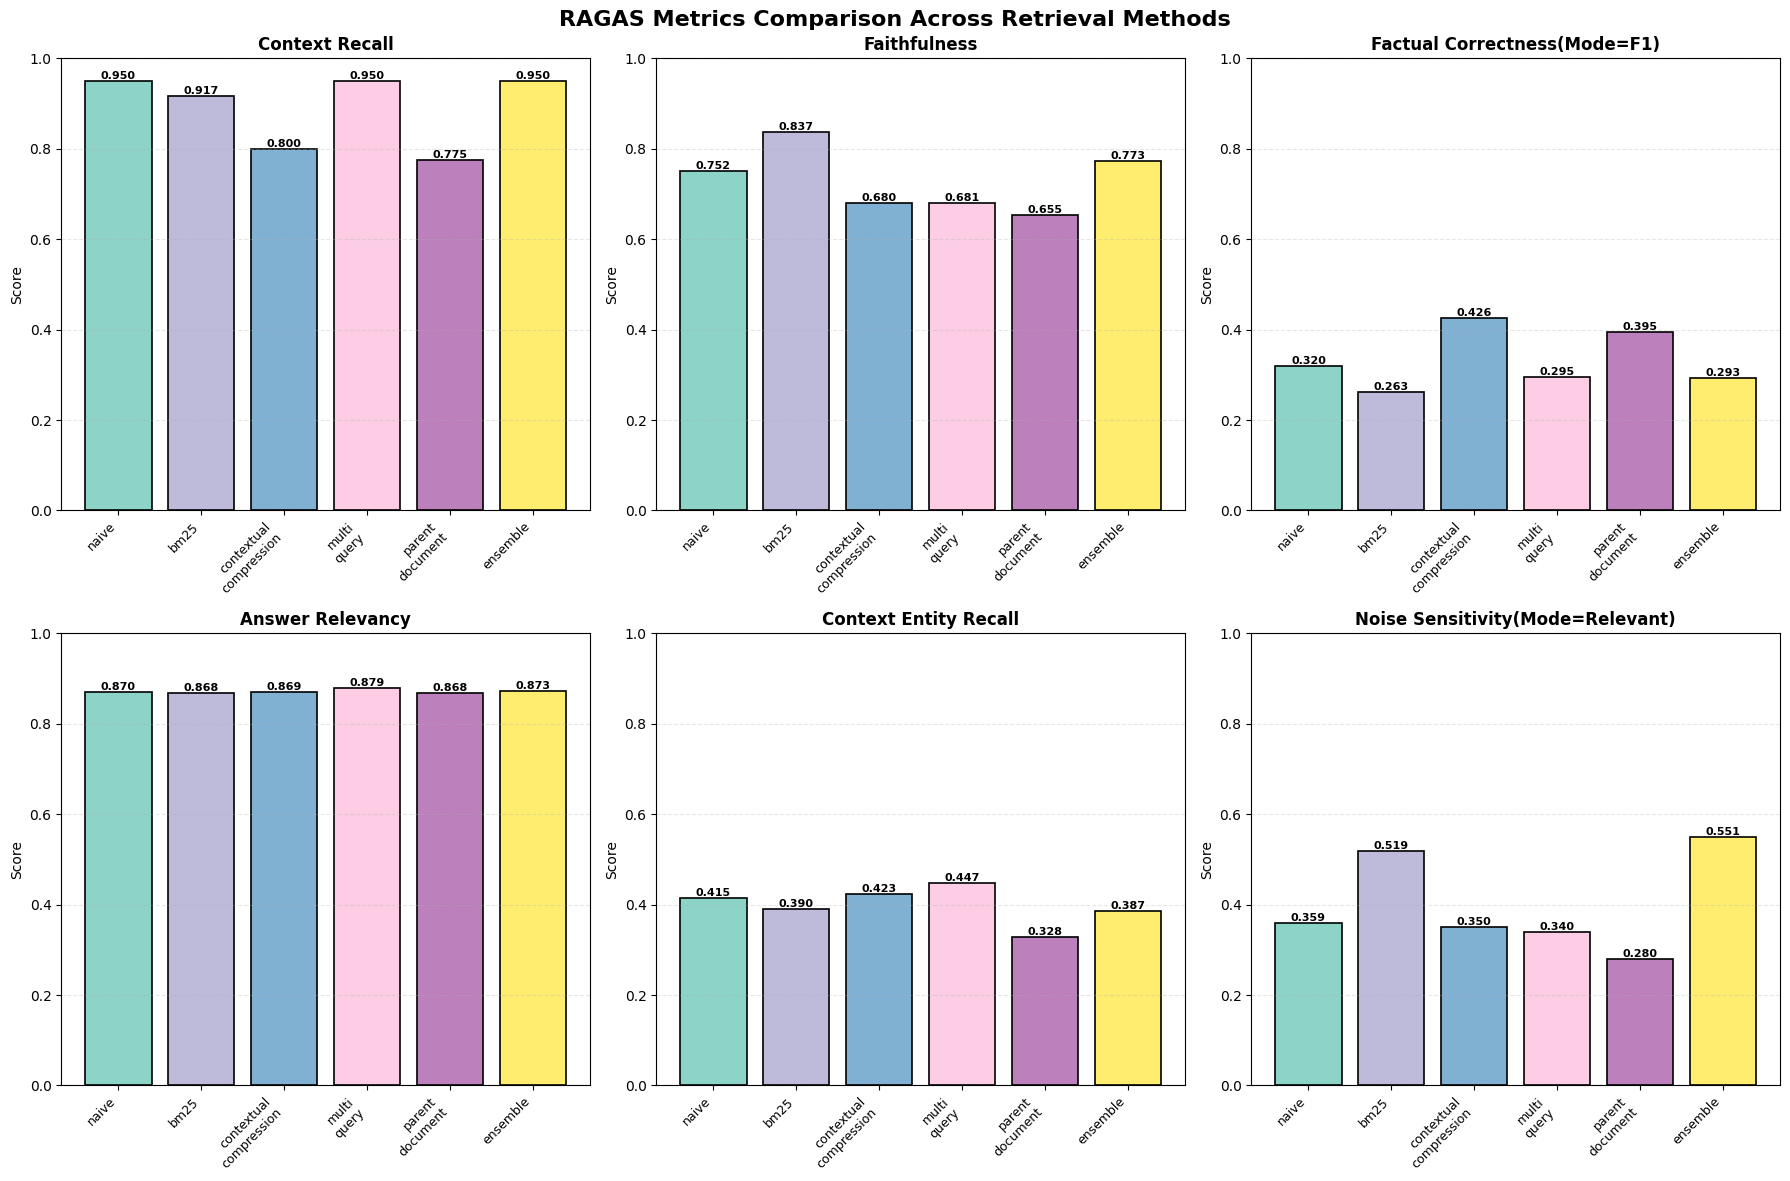

In [149]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Extract metrics from retriever_results
metrics_data = {}

for chain_name, result in retriever_results.items():
    # Convert EvaluationResult to dictionary with metric scores
    metrics_data[chain_name] = result.to_pandas().drop(columns=['user_input', 'retrieved_contexts', 'response', 'reference', 'reference_contexts']).mean().to_dict()

# Create DataFrame for easier plotting
metrics_df = pd.DataFrame(metrics_data).T

# Display the metrics table
# print("📊 RAGAS Metrics Comparison Across Retrievers")
# print("=" * 80)
# print(metrics_df.round(4))
# print("\n")

# Create visualizations
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('RAGAS Metrics Comparison Across Retrieval Methods', fontsize=16, fontweight='bold')

# Get metric names and retrievers
metric_names = list(metrics_df.columns)
retrievers = list(metrics_df.index)

# Color palette
colors = plt.cm.Set3(np.linspace(0, 1, len(retrievers)))

# Plot each metric in a subplot
for idx, metric in enumerate(metric_names):
    row = idx // 3
    col = idx % 3
    ax = axes[row, col]
    
    values = metrics_df[metric].values
    bars = ax.bar(range(len(retrievers)), values, color=colors, edgecolor='black', linewidth=1.2)
    
    # Customize subplot
    ax.set_title(metric.replace('_', ' ').title(), fontsize=12, fontweight='bold')
    ax.set_xticks(range(len(retrievers)))
    ax.set_xticklabels([r.replace('_retrieval_chain', '').replace('_', '\n') for r in retrievers], rotation=45, ha='right', fontsize=9)
    ax.set_ylabel('Score', fontsize=10)
    ax.set_ylim(0, 1.0)
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    
    # Add value labels on bars
    for i, (bar, value) in enumerate(zip(bars, values)):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{value:.3f}',
                ha='center', va='bottom', fontsize=8, fontweight='bold')

plt.tight_layout()
plt.show()


##### RAGA's metric result Summary

In [151]:
# Calculate and display overall rankings
print("\n📈 Overall Performance Ranking")
print("=" * 80)
metrics_df['average_score'] = metrics_df.mean(axis=1)
ranking = metrics_df.sort_values('average_score', ascending=False)
print(ranking[['average_score']].round(4))

# Find best retriever for each metric
print("\n🎯 Best Retriever Per Metric")
print("=" * 80)
for metric in metric_names:
    best_retriever = metrics_df[metric].idxmax()
    best_score = metrics_df[metric].max()
    print(f"{metric.replace('_', ' ').title():30s}: {best_retriever.replace('_', ' ').title():40s} ({best_score:.4f})")



📈 Overall Performance Ranking
                                        average_score
ensemble_retrieval_chain                       0.6378
bm25_retrieval_chain                           0.6324
naive_retrieval_chain                          0.6109
multi_query_retrieval_chain                    0.5986
contextual_compression_retrieval_chain         0.5914
parent_document_retrieval_chain                0.5501

🎯 Best Retriever Per Metric
Context Recall                : Naive Retrieval Chain                    (0.9500)
Faithfulness                  : Bm25 Retrieval Chain                     (0.8374)
Factual Correctness(Mode=F1)  : Contextual Compression Retrieval Chain   (0.4260)
Answer Relevancy              : Multi Query Retrieval Chain              (0.8792)
Context Entity Recall         : Multi Query Retrieval Chain              (0.4468)
Noise Sensitivity(Mode=Relevant): Ensemble Retrieval Chain                 (0.5505)


##### ✅ Answer:

##### Results conclusion

Based on the results obtained by RAGAS evaluation, we can conclude a few things.

 * the best overall retriever for the dataset (Research Paper PDF) used in our experiment is the **Ensemble Retrieval** which combines multiple retriever methods to provide more relevat and diverse results. Because it use different retrievers it relies on a special algorithm to merge the ranked list of docs from each retriever.
  
 * the **BM25** retriever achieved the best score for **Faithfulness** metric which measures how factually consistent a response is with the retrieved context. The BM25 algorithm focuses on keyword matching to determine document relevance which confirms the high score for this metric in our experiment.

 * surprisingly the **Naive** retriever achieved the same high score (95%) for **Context Recall** metric compared to more sofisticated retrievers like **Ensemble** and **Multi-query** in our experiment. Context Recall measures how many of the relevant documents (or pieces of information) were successfully retrieved.

 * the **Contextual Compression** retriever achieved superior **Factual Correctness** when compared to all the other retrievers in our experiment. This metric is used to determine the extent to which the generated response aligns with the reference. The fact it uses a rehanker model (Cohere) might contribute to its performance on this specific metric. The **Parent Document** retriever appears in second for this metric, followed by **Multi-query**.

 * in terms of **Answer Relevancy**, all the retrievers achieved about the same score with very small differences. This metric measures how relevant a response is to the user input.

 * the **Parent Document** retriever achieved the best **Noise Sensitivity** (smaller score means better result) among all retriever in our experiment. This metric measures how often a system makes errors by providing incorrect responses when utilizing either relevant or irrelevant retrieved documents. 

#### LangSmith Evaluation

In [142]:
from langsmith import Client

langsmith_client = Client()

dataset_name = "AIE8 - Assignment 9 - AI Usage Synthetic Data"
langsmith_dataset = langsmith_client.create_dataset(
    dataset_name=dataset_name,
    description="Synthetic Data for Use Cases - AIE8 - Assignment 9 - Advanced Retrieval"
)

##### Dataset mapping

In [ ]:
for data_row in dataset.to_pandas().iterrows():
  langsmith_client.create_example(
      inputs={
          "question": data_row[1]["user_input"]
      },
      outputs={
          "answer": data_row[1]["reference"]
      },
      metadata={
          "context": data_row[1]["reference_contexts"]
      },
      dataset_id=langsmith_dataset.id
  )

##### Evaluation setup

In [ ]:
from langsmith.evaluation import LangChainStringEvaluator, evaluate

eval_llm = ChatOpenAI(model="gpt-4.1")

# Question-Answering evaluator that compares the output to a reference answer
#  - Compares the model's output against a reference answer
#  - Determines if the response is factually correct
#  - Works well for checking accuracy of responses
qa_evaluator = LangChainStringEvaluator(
    "qa", 
    config={"llm" : eval_llm},
    prepare_data=lambda run, example: {
        "prediction": run.outputs["response"],
        "reference": example.outputs["answer"],
        "input": example.inputs["question"],
    }
)

for chain_name, chain in retriever_chains_dict.items():
    print(f"Evaluating retrieval chain: {chain_name}")
    # ragas_dataset = EvaluationDataset.from_pandas(retriever_datasets[chain_name].to_pandas())
    experiment_result = evaluate(
        chain.invoke,
        data=dataset_name,
        evaluators=[
            qa_evaluator,
            # labeled_helpfulness_evaluator
        ],
        metadata={"revision_id": "default_chain_init"},
        experiment_prefix=chain_name
    )

##### LangSmith Evaluation - experiments cost and latency comparison

![](./langsmith_retrievel_cost_comparison.png)